In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load the training data
X_train = pd.read_csv('/Users/aminosaurier/Downloads/spring_2025_startup_survival/new-analysis/X_train.csv')
y_train = pd.read_csv('/Users/aminosaurier/Downloads/spring_2025_startup_survival/new-analysis/y_train.csv')

# Convert y_train to a 1D array (required format for sklearn)
y_train = y_train['success_binary'].values

# Display basic information about the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Number of positive class samples: {sum(y_train)}")
print(f"Number of negative class samples: {len(y_train) - sum(y_train)}")
print(f"Class distribution: {sum(y_train)/len(y_train):.2f} (positive) / {1-sum(y_train)/len(y_train):.2f} (negative)")

# Display first few rows of X_train
print("\nFirst 5 rows of X_train:")
print(X_train.head())

X_train shape: (41290, 5)
y_train shape: (41290,)
Number of positive class samples: 13386
Number of negative class samples: 27904
Class distribution: 0.32 (positive) / 0.68 (negative)

First 5 rows of X_train:
   funding_rounds  funding_total_usd  milestones  relationships       age
0        1.061713           0.203911    2.440358       0.002626  0.694242
1       -0.573306          -0.199304   -0.821018      -0.201348 -0.255226
2       -0.573306          -0.199304   -0.821018      -0.065365  0.061264
3        1.061713           4.647531    0.266107       1.294464  2.698674
4        1.061713          -0.160714   -0.821018      -0.065365 -0.571715


In [3]:
# Train a basic logistic regression model with default parameters
# We'll use this as a baseline before tuning
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# Evaluate the baseline model using cross-validation
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Baseline model cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Baseline model cross-validation accuracy: 0.9254 ± 0.0026


In [4]:
# Perform hyperparameter tuning using GridSearchCV
# We'll try different values for regularization strength (C) and penalty type
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear supports both l1 and l2 penalties
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

print("Starting grid search for hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Starting grid search for hyperparameter tuning...
Best parameters: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9346


In [5]:
# Train the final model with the best parameters
best_params = grid_search.best_params_
final_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=best_params['max_iter'],
    random_state=42
)

print(f"Training final model with parameters: {best_params}")
final_model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = final_model.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

Training final model with parameters: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Training accuracy: 0.9337



Top 10 most important features:
             Feature  Coefficient  Abs_Coefficient
4                age     4.347580         4.347580
2         milestones     0.046611         0.046611
0     funding_rounds     0.000000         0.000000
1  funding_total_usd     0.000000         0.000000
3      relationships     0.000000         0.000000


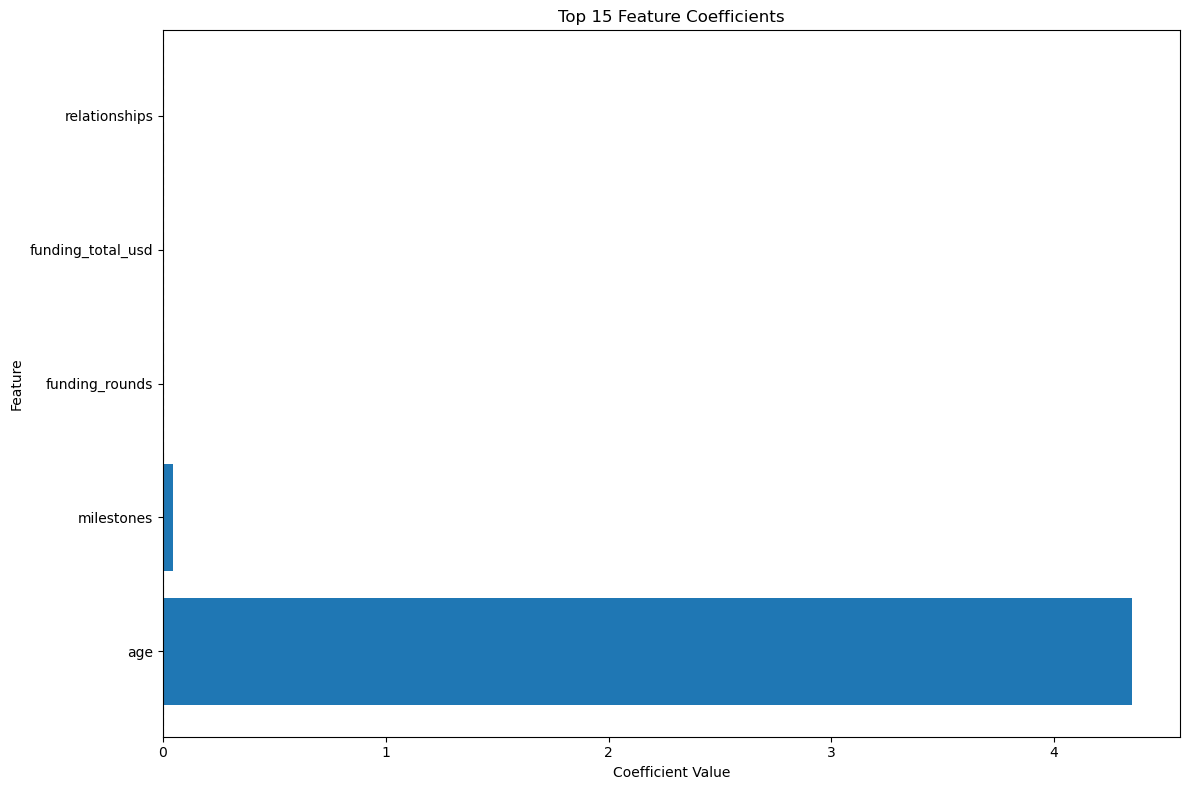

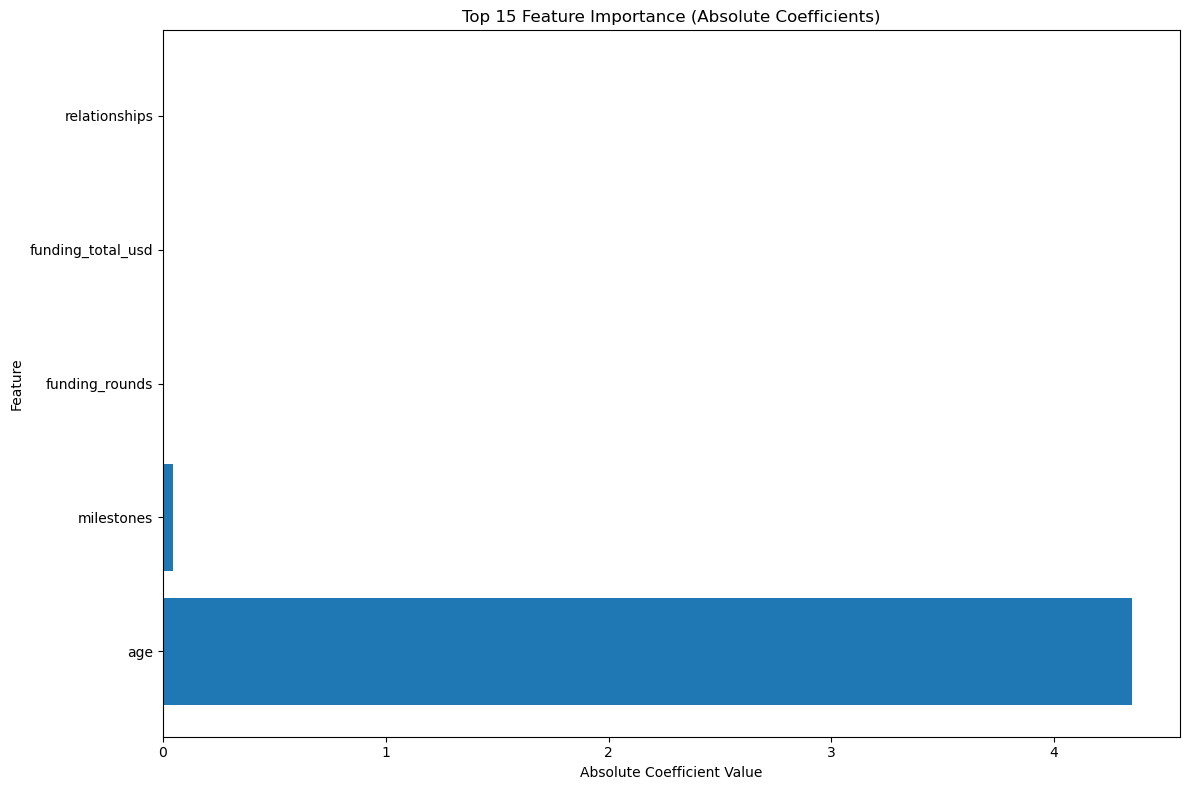

In [6]:
# Examine the coefficients of the model to understand feature importance

# First, let's check if all coefficients are zero (which indicates a problem)
if np.all(final_model.coef_[0] == 0):
    print("WARNING: All coefficients are zero. This suggests excessive regularization.")
    print(f"Current model parameters: {best_params}")
    
    # Train a new model with less regularization for feature importance analysis
    print("\nTraining a model with less regularization for feature importance analysis...")
    analysis_model = LogisticRegression(
        C=1.0,  # Higher C means less regularization
        penalty='l2',  # L2 is less likely to zero out coefficients completely
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    analysis_model.fit(X_train, y_train)
    
    # Calculate and print accuracy of this analysis model
    analysis_accuracy = analysis_model.score(X_train, y_train)
    print(f"Analysis model accuracy: {analysis_accuracy:.4f}")
    
    # Use this model's coefficients for feature importance
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': analysis_model.coef_[0]
    })
else:
    # Use the original model if coefficients are not all zero
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': final_model.coef_[0]
    })

# Sort by absolute coefficient value to see most important features
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 most important features:")
print(coefficients.head(10))

# Plot the coefficients
plt.figure(figsize=(12, 8))
top_features = coefficients.head(15)  # Increased to show more features
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Feature Coefficients')
plt.axvline(x=0, color='gray', linestyle='--')  # Add a vertical line at x=0 for reference
plt.tight_layout()
plt.savefig('coefficient_plot.png')
plt.show()  # Added to display the plot in the notebook

# Also create a plot of absolute coefficient values
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Absolute Coefficients)')
plt.tight_layout()
plt.savefig('abs_coefficient_plot.png')
plt.show()

In [7]:
# Additional analysis: Examine the decision boundary
# Calculate the predicted probabilities for the training data
y_pred_proba = final_model.predict_proba(X_train)[:, 1]

# Create a histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_train == 0], bins=20, alpha=0.5, label='Negative class (0)')
plt.hist(y_pred_proba[y_train == 1], bins=20, alpha=0.5, label='Positive class (1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.savefig('probability_distribution.png')  # Save the plot for reference
plt.close()

print("Model building and analysis complete!")

Model building and analysis complete!
